In [1]:
import glob
import json
import time
import sys
import asyncio
import numpy as np
import matplotlib.pyplot as plt
import time
import glob
import asyncio
import aiohttp
import random
import time
%matplotlib notebook

# source likelihoods needed to reproduce results
LIKELIHOOD  = 'https://www.hepdata.net/record/resource/997020?view=true'

# cloud resources to re-perform stat. analysis
FITTING_SVC = None

!curl -s {LIKELIHOOD} |tar -xzf -

In [2]:
data_live = None
done_live = None
def reset_data_live():
    global data_live
    global done_live
    data_live = {'A': {}, 'C': {}}
    done_live = {'A': False, 'C': False}

async def from_online(key,session,url,patch):
    region = url[-1]
    resp = await session.post(url,data = patch)
    result = (resp.status, await resp.json())
    data_live[region][key] = result
    return result

async def fetch_html(url: str, session: aiohttp.ClientSession, patch) -> tuple:
    key,patch = patch
    for i in range(10):
        try:
            result = (key,await from_online(key,session,url,patch))
            return result
        except:
            pass
    return ('404',(key,{}))

async def make_requests(url, patches: set, **kwargs) -> None:
    async with aiohttp.ClientSession(headers = {"Content-Type": "application/json"}) as session:
        tasks = []
        for patch in patches:
            tasks.append(
                fetch_html(url=url, session=session, patch = patch,)
            )
        
        results = await asyncio.gather(*tasks)
    return results

async def run_region(region = 'A'):
    start = time.time()
    patches = list({x: open(x).read() for x in glob.glob(f'Region{region}/patch.sbottom_*_60.json')}.items())
    print(f'Number of Patches: {len(patches)}')
    results = await make_requests(f'{FITTING_SVC}/region{region}',patches[:])
    all_ok = np.all([x[1][0]==200 for x in results])
    print(f'->Number of Results: {len(results)} {time.time()-start} | {all_ok}')
    done_live[region] = True
    return results

In [7]:
def plot(ax,data,color = 'steelblue', label = '(in progress)'):
    ax.cla()
    
    hdata = [
        ('regionA',[make_harvest_from_result(k,r[1]) for k,r in data_live['A'].items()]),
        ('regionC',[make_harvest_from_result(k,r[1]) for k,r in data_live['C'].items()]),
    ]
    
    
    
    if len(hdata[0][1]) > 3 and len(hdata[1][1]) > 3:
        make_plot(ax,
            dataList = hdata,
            label = f'Open Likelihood {label}', color = color, showPoints = True, showInterPolated = True
        )
    else:
        apply_decorations(ax,label = f'Open Likelihood {label}')
    ax.text(0.5,0,f'{len(data_live["A"])},{len(data_live["C"])}')
    fig.set_tight_layout(True)
    fig.canvas.draw()

async def plotting_loop():
    global data_live
    global done_live
    while not (done_live['A'] and done_live['C']):
        plot(ax,data_live)
        await asyncio.sleep(0.2)
    plot(ax,data_live,color = 'gold', label = '')
    print('done plotting')

<IPython.core.display.Javascript object>


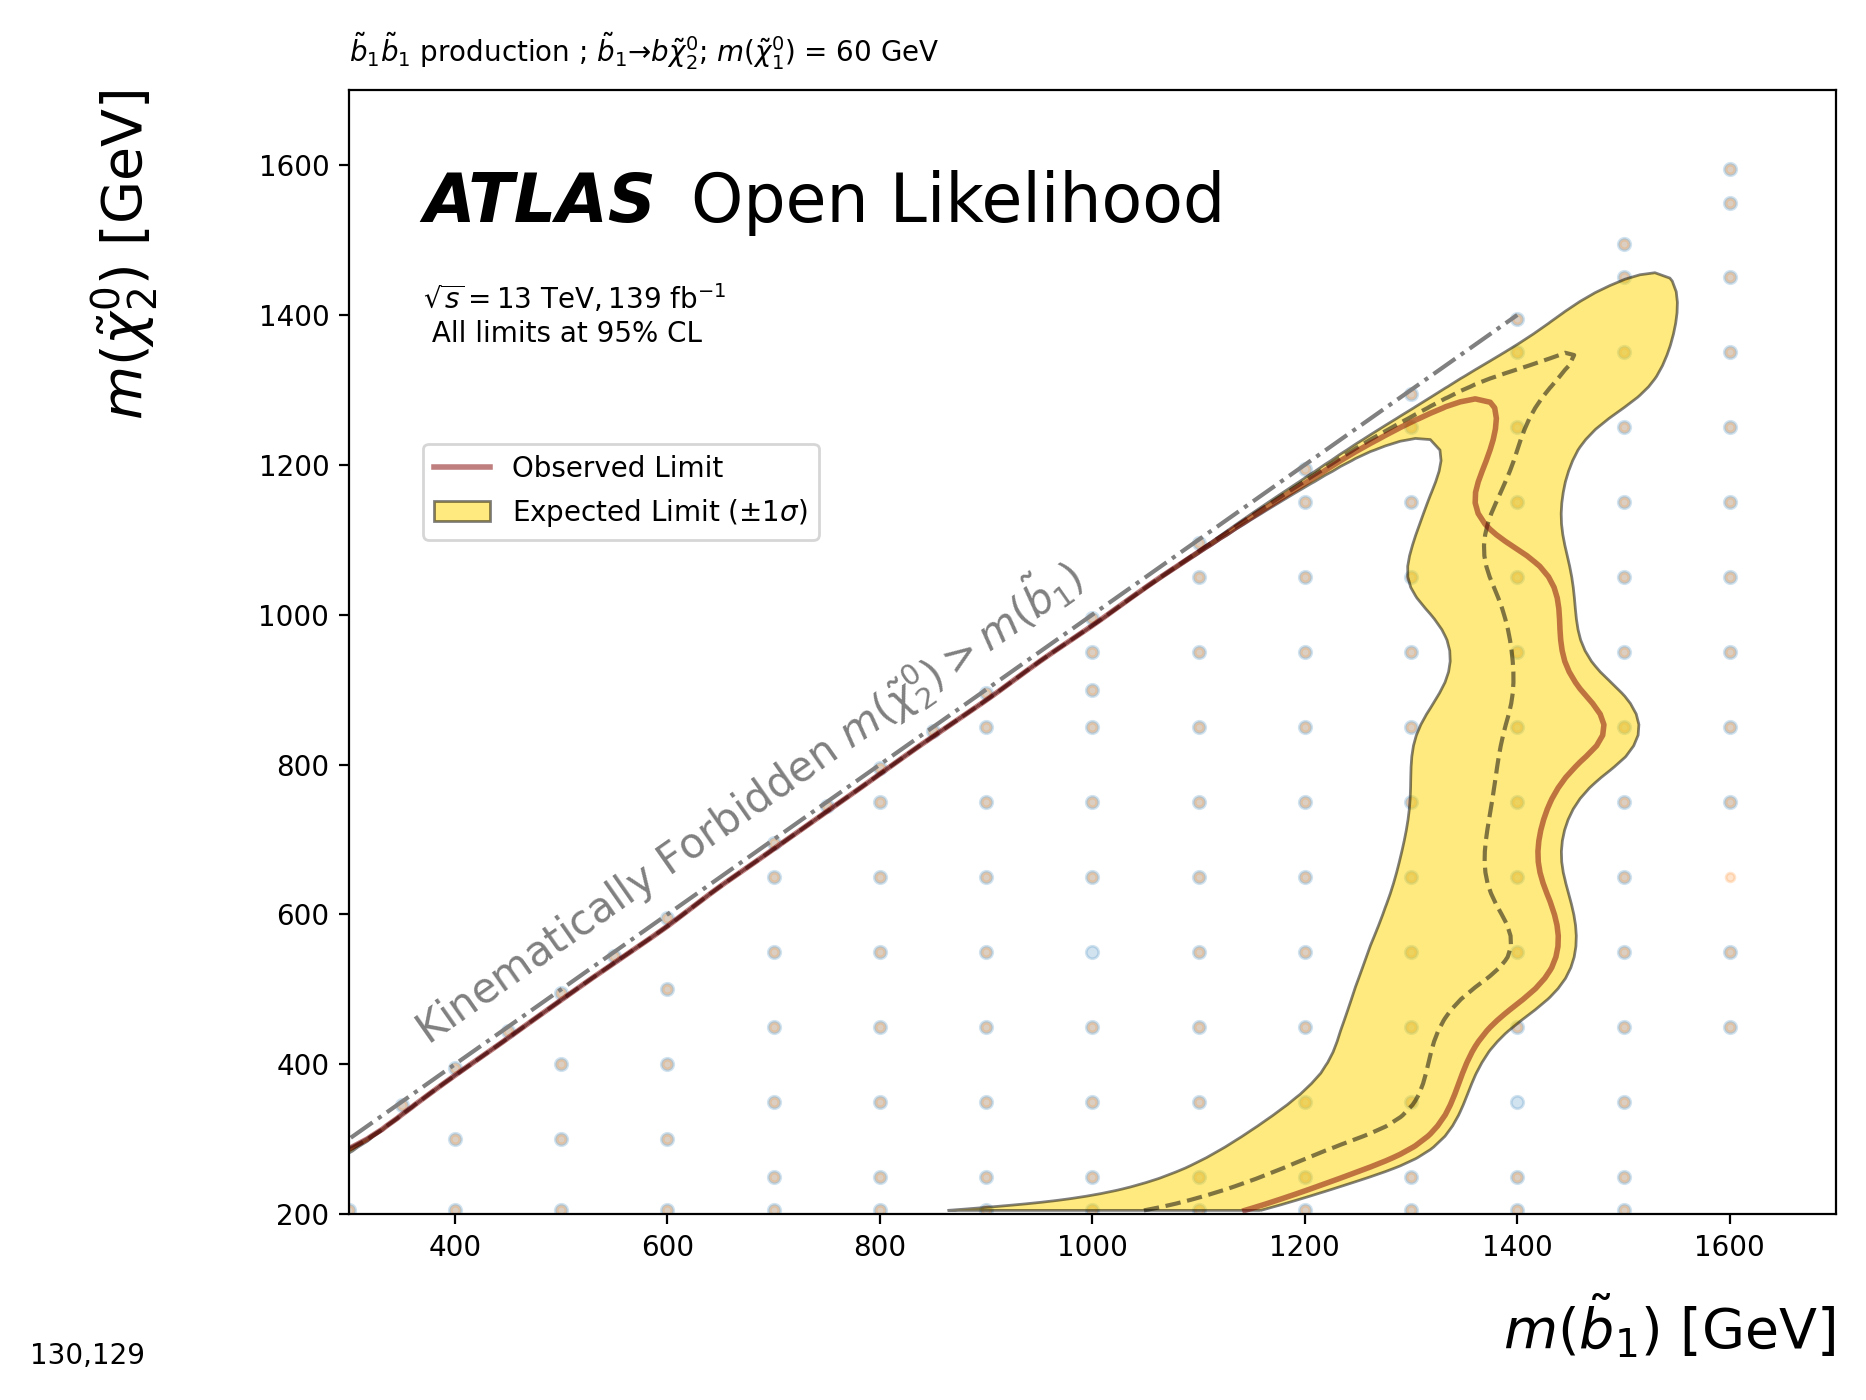

No handles with labels found to put in legend.


In [9]:
from plotting import make_harvest_from_result, make_plot, apply_decorations
fig,ax = plt.subplots(1,1)
fig.set_size_inches(9.33,7)
apply_decorations(ax,label = 'Open Likelihood (in progress)')
fig.set_tight_layout(True)

In [10]:
reset_data_live()
plot(ax,data_live)
start = time.time()
results = await asyncio.gather(run_region('A'),run_region('C'),plotting_loop())
time.time()-start

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Number of Patches: 130
Number of Patches: 129


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/Users/lukasheinrich/Code/pyhfdev/fittingsvc/lhoodbinder2/interpolate.py:367: UserWarning: No contour levels were found within the data range.
  c = ax.contour(xi,yi,zi, [level])
/Users/lukasheinrich/Code/pyhfdev/fittingsvc/lhoodbinder2/interpolate.py:367: UserWarning: No contour levels were found within the data range.
  c = ax.contour(xi,yi,zi, [level])
/Users/lukasheinrich/Code/pyhfd

->Number of Results: 130 66.33911490440369 | True
->Number of Results: 129 66.28016376495361 | True


/Users/lukasheinrich/Code/pyhfdev/fittingsvc/lhoodbinder2/interpolate.py:367: UserWarning: No contour levels were found within the data range.
  c = ax.contour(xi,yi,zi, [level])


done plotting


69.64476585388184

In [ ]:
!cat ./environment.yml